In [3]:
# required google colab installations
!pip install torchinfo tqdm torchmetrics wandb mlxtend==0.22

     ---------------------------------------- 77.1/77.1 kB ? eta 0:00:00


In [4]:
# import libraries
import random
import math
from pathlib import Path
import sys

from tqdm.auto import tqdm


import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

import torchinfo # show model summary

# helper functions 
#from helpers import display_images

# pytorch modules
import torch
from torch.utils.data import DataLoader

# torch vision modules
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch import nn

# metrics module
import torchmetrics

# tracking metrics
import wandb

c:\Users\musta\anaconda3\envs\deeplearning\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##### Hyper-parameter Initialisations

In [6]:
config = dict(
    epochs=10,
    learning_rate=1e-2,
    batch_size= 32,
    optimiser="SGD",
    dataset="CIFAR",
    architecture="ResNet-18",
)

In [7]:
run_name = f"{config['architecture']}_{config['optimiser']}_{config['learning_rate']}_{config['batch_size']}_{config['dataset']}"
print(run_name)

ResNet-18_ADAM_0.01_32_MNIST


In [8]:
# initialise wandb project
wandb.init(project="ECS795P_CIFAR", config=config, name=run_name)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\musta/.netrc


In [9]:
config = wandb.config
print(f"Hyper-parameter configurations: \n{config}")

Hyper-parameter configurations: 
{'epochs': 10, 'learning_rate': 0.01, 'batch_size': 32, 'optimiser': 'ADAM', 'dataset': 'MNIST', 'architecture': 'ResNet-18'}


In [10]:
def display_images(image_dataloader: DataLoader, class_labels, n_rows: int =3, n_cols:int =5, figsize: tuple =(12,6)):

    """
    displays images from dataloader
    """
    # display data sample images
    #n_rows, n_cols = 3, 5
    n_samples = n_rows * n_cols # number sample images to display

    data, label = next(iter(image_dataloader))
    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)

    for i, image in enumerate(data[:n_samples]):
        image = image.detach()[0]
        #image = image.squeeze(dim=0)
        axs[i%n_rows, i//n_rows].imshow(image.numpy(), cmap="gray")
        axs[i%n_rows, i//n_rows].set(xticks=[], yticks=[])
        axs[i%n_rows, i//n_rows].set_title(class_labels[label[i]])
        
    return fig

In [11]:
def display_predicted_images(model, image_dataloader: DataLoader, class_labels, n_rows: int =3, n_cols:int =5, figsize: tuple =(12,6)):

    """
    displays images from dataloader
    """
    # display data sample images
    n_samples = n_rows * n_cols # number sample images to display

    data, label = next(iter(image_dataloader))

    model = model.to("cpu")

    model.eval()
    with torch.inference_mode():
        model_predictions_logits = model(data)
        predictions = nn.functional.softmax(model_predictions_logits, dim=0).argmax(dim=1)

    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)

    for i, image in enumerate(data[:n_samples]):
        image = image.detach()[0]
        #image = image.squeeze(dim=0)
        axs[i%n_rows, i//n_rows].imshow(image.numpy(), cmap="gray")
        axs[i%n_rows, i//n_rows].set(xticks=[], yticks=[])
        title = f"Actual Class {class_labels[label[i]]}\n Predicted Class: {class_labels[predictions[i]]}"
        axs[i%n_rows, i//n_rows].set_title(title)

    return fig

In [12]:
# device agnostic code
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Current hardware device: {DEVICE}")

Current hardware device: cpu


#### Downloading and Loading Datasets

In [ ]:
# load CIFAR10 datasets
# CIFAR10 train data
train_data = datasets.CIFAR10(
    root="cifar_data",
    train=True,
    transform=transforms.ToTensor(),
    download=True,
)

# CIFAR10 test data
test_data = datasets.CIFAR10(
    root="cifar_data",
    transform=transforms.ToTensor(),
    train=False,
    download=True,
)

In [ ]:
print(f"Train data size: {len(train_data)}")
print(f"Test data size: {len(test_data)}")
print(f"Image size: {np.array(train_data[0][0].shape)}")

Train data size: 50000
Test data size: 10000
Image size: [  3 224 224]


In [ ]:
class_labels = train_data.classes # images class labels
print(f"class labels: {class_labels}")

class labels: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
# train dataloader iterable
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=config.batch_size,
    shuffle=True
)

# test dataloader iterable
test_dataloader= DataLoader(
    dataset=test_data,
    batch_size=config.batch_size,
)

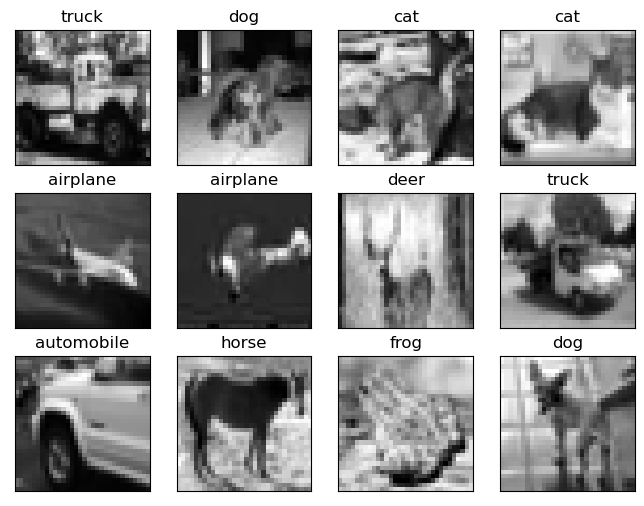

In [ ]:
display_images(train_dataloader, class_labels=class_labels, n_cols=4, n_rows=3, figsize=(8,6))
plt.show()

In [ ]:
# calculate train and test dataset means and standard deviations
train_data_mean = train_data.data.mean(axis=(0,1,2))/225
train_data_std = train_data.data.std(axis=(0,1,2))/225
test_data_mean = test_data.data.mean(axis=(0,1,2))/225
test_data_std = test_data.data.std(axis=(0,1,2))/225

print(f"Train data mean: {train_data_mean}\t Train data standard deviation: {train_data_std}")
print(f"test data mean: {test_data_mean}\t Test data standard deviation: {test_data_std}")

Train data mean: [0.55691964 0.5464462  0.50606837]	 Train data standard deviation: [0.27996986 0.27594981 0.29646622]
test data mean: [0.56010952 0.54981557 0.51046364]	 Test data standard deviation: [0.27953952 0.2752779  0.29647136]


In [ ]:
# Train dataset Transforms
train_tranforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=(0, 180)),
    transforms.RandomHorizontalFlip(0.3),
    transforms.ToTensor(),
    transforms.Normalize(train_data_mean, train_data_std)
    ])

# Test dataset Transforms
test_tranforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(test_data_mean, train_data_std)
    ])

In [ ]:
# CIFAR train data with transforms
train_data = datasets.CIFAR10(
    root="cifar_data",
    train=True,
    transform=train_tranforms,
    download=True,
)

# CIFAR test data with transforms
test_data = datasets.CIFAR10(
    root="cifar_data",
    train=False,
    transform=test_tranforms,
    download=True,
)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# train dataloader iterable
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=config.batch_size,
    shuffle=True
)

# test dataloader iterable
test_dataloader= DataLoader(
    dataset=test_data,
    batch_size=config.batch_size,
)

#### ResNet-18 Baseline Model

In [19]:
resnet_model = torchvision.models.resnet18()

In [20]:
# set the output of the FC layers to number of classes of CIFAR

resnet_fc = nn.Linear(in_features=512, out_features=len(class_labels), bias=True)
resnet_model.fc = resnet_fc

In [21]:
# display model architecture
torchinfo.summary(resnet_model,
                  input_size=(32, 3, 224, 224), 
                  col_names=["input_size", "output_size", "num_params", "trainable"],
                  col_width=60,
                  row_settings=["var_names"]
                  )

Layer (type (var_name))                  Input Shape                                                  Output Shape                                                 Param #                                                      Trainable
ResNet (ResNet)                          [32, 3, 224, 224]                                            [32, 10]                                                     --                                                           True
├─Conv2d (conv1)                         [32, 3, 224, 224]                                            [32, 64, 112, 112]                                           9,408                                                        True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]                                           [32, 64, 112, 112]                                           128                                                          True
├─ReLU (relu)                            [32, 64, 112, 112]                    

In [22]:
loss_fn = nn.CrossEntropyLoss()
if config.optimiser == "SGD":
    optimiser = torch.optim.SGD(resnet_model.parameters(), lr=config.learning_rate)
elif config.optimiser == "ADAM":
    optimiser = torch.optim.Adam(resnet_model.parameters(), lr=config.learning_rate)

In [23]:
# metrics definition
accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=10)

In [22]:
# monitor parameter values i.e weights and biases and model gradients
wandb.watch(resnet_model, criterion=loss_fn, log="all")

[]

In [23]:
def train_model(model, dataloader: torch.utils.data.DataLoader):
    """
    
    """
    train_acc, train_loss = 0, 0
    model.train()
    for batch_data, batch_label in train_dataloader:
        batch_data = batch_data.to(DEVICE)
        batch_label = batch_label.to(DEVICE)\

        pred_logits = model(batch_data)

        train_batch_loss = loss_fn(pred_logits, batch_label)
        train_loss += train_batch_loss

        preds = nn.functional.softmax(pred_logits, dim=0).argmax(dim=1)
        
        train_batch_acc = accuracy_metric(preds.cpu(), batch_label.cpu()) * 100
        train_acc += train_batch_acc

        optimiser.zero_grad()

        train_batch_loss.backward()

        optimiser.step()
    
    # average of metrics per batch
    train_acc /= len(train_dataloader)
    train_loss /= len(train_dataloader)

    return train_loss, train_acc

In [24]:
def test_model(model, dataloader: torch.utils.data.DataLoader):
    """
    
    """
    test_loss, test_acc =  0, 0
    model.eval() # set model to evaluation mode
    with torch.inference_mode():
        for test_batch_data, test_batch_label in dataloader:

            test_batch_data = test_batch_data.to(DEVICE)
            test_batch_label = test_batch_label.to(DEVICE)

            pred_logits = model(test_batch_data)

            test_batch_loss = loss_fn(pred_logits, test_batch_label)
            test_loss += test_batch_loss

            preds = nn.functional.softmax(pred_logits, dim=0).argmax(dim=1)
            
            batch_acc = accuracy_metric(preds.cpu(), test_batch_label.cpu()) * 100
            test_acc += batch_acc
        
        # average of loss metrics
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
    return test_loss, test_acc

In [25]:
def model_prediction(model, dataloader: torch.utils.data.DataLoader):
    """
    
    """
    all_preds = []
    model.to(DEVICE)
    model.eval() # set model to evaluation mode
    with torch.inference_mode():
        for test_batch_data, test_batch_label in dataloader:

            test_batch_data = test_batch_data.to(DEVICE)
            test_batch_label = test_batch_label.to(DEVICE)

            pred_logits = model(test_batch_data)
            preds = nn.functional.softmax(pred_logits, dim=0).argmax(dim=1)
            
            all_preds.append(preds.to("cpu"))
        
    all_preds_tensor = torch.cat(all_preds)
    return all_preds_tensor

##### Model Training

In [26]:

for epoch in tqdm(range(config.epochs)):

    # MODEL TRAINING
    train_loss, train_accuracy = train_model(resnet_model, train_dataloader)

    # MODEL EVALUATION
    test_loss, test_accuracy = test_model(resnet_model, test_dataloader)
    
    # print training metrics
    print(f"Epoch: {epoch}")
    print(f"Training loss: {train_loss: .3f}\t Training accuracy: {train_accuracy: .3f}", end="\t")
    print(f"Test loss: {test_loss: .3f}\t Test acc: {test_accuracy: .3f}")

    # log epoch metrics to WandB
    epoch_log_dict = {
        "training_accuracy": train_accuracy,
        "training_loss": train_loss,
        "test_loss": test_loss,
        "test_accuracy": test_accuracy
    }
    wandb.log(epoch_log_dict)



  0%|          | 0/1 [00:00<?, ?it/s]

: 

: 

## Visualisations

#### Model accuracy and loss


In [ ]:
# show logged metrics
%wandb mustious/ECS795P_Classic

#### Sample Images of Predicted Classes

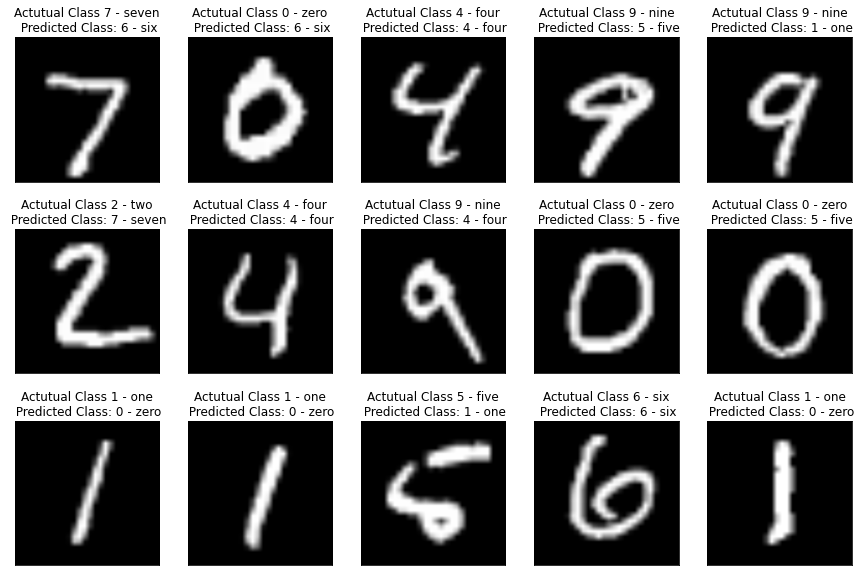

In [ ]:
predicted_images_fig = display_predicted_images(resnet_model, test_dataloader, class_labels=class_labels, figsize=(15,10))
plt.savefig(f"{config.architecture}_sample_model_prediction.jpg")
plt.show()

# log prediction image in wandb
wandb.log({"sample_predictions": predicted_images_fig})

#### Confusion Matrix Visualisation


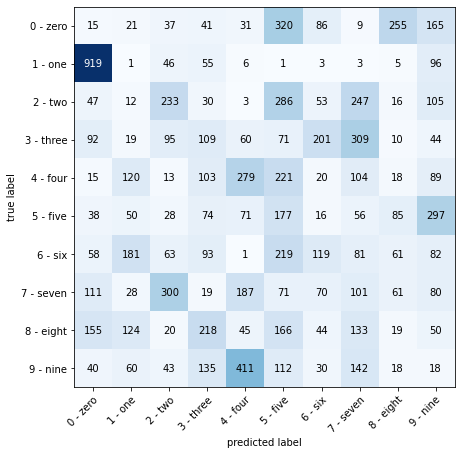

In [ ]:
predictions = model_prediction(resnet_model, test_dataloader)

confusion_matrix = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=len(class_labels))
confusion_matrix_tensor = confusion_matrix(predictions, torch.Tensor(test_data.targets))
confusion_matrix_fig, ax = plot_confusion_matrix(
    confusion_matrix_tensor.numpy(),
    class_names= class_labels,
    figsize=(10, 7))
plt.show()

# log prediction image in wandb
wandb.log({"confusion_matrix": confusion_matrix_fig})